In [16]:
#new 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

In [17]:
'''Data loading '''
def load_dataset(file_path, target_column):
    df = pd.read_csv(file_path)
    print(f"Loaded dataset: {file_path} with shape: {df.shape}")

    # checking target_column if exist
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found in the dataset.")
        return None, None

    # Converting target column to binary (0 for negative, 1 for positive)
    y = (df[target_column] == 1).astype(int)
    X = pd.get_dummies(df.drop(columns=[target_column]))
    
    # Imputing missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    return X_imputed, y


In [18]:
'''Constructing a tetrahedron around a positive point with specific neighbors'''
def construct_tetrahedron(pos_point, negative_samples, positive_samples):
    nbrs_neg = NearestNeighbors(n_neighbors=5).fit(negative_samples)
    _, neg_indices = nbrs_neg.kneighbors([pos_point])
    chosen_negatives = negative_samples[neg_indices[0][[0, 2]]]  # First and third nearest neighbors
    
    centroid = np.mean(np.vstack([pos_point, chosen_negatives]), axis=0)
    
    nbrs_pos = NearestNeighbors(n_neighbors=1).fit(positive_samples)
    _, pos_indices = nbrs_pos.kneighbors([centroid])
    chosen_positive = positive_samples[pos_indices[0][0]]
    
    tetrahedron_vertices = np.vstack([pos_point, chosen_negatives, chosen_positive])
    
    return tetrahedron_vertices if tetrahedron_vertices.shape[0] == 4 else None

In [19]:
''' Checking if a point is inside a tetrahedron '''
def is_point_inside_tetrahedron(point, A, B, C, D):
    def signed_volume(P, Q, R, S):
        return np.dot(np.cross(Q - P, R - P), S - P) / 6

    vol_tetra = signed_volume(A, B, C, D)
    vol1 = signed_volume(point, B, C, D)
    vol2 = signed_volume(A, point, C, D)
    vol3 = signed_volume(A, B, point, D)
    vol4 = signed_volume(A, B, C, point)
    return np.abs(vol_tetra - (vol1 + vol2 + vol3 + vol4)) < 1e-6

In [20]:
''' Computing the volume of a tetrahedron '''
def compute_tetrahedron_volume(vertices):
    A = np.ones((4, 4))
    A[1:, :] = vertices.T
    volume = np.abs(np.linalg.det(A)) / 6
    return volume if volume > 0 else 1e-6

In [21]:
'''Calculating the density of points within a tetrahedron'''
def density(tetrahedron_vertices, positive_points):
    count_positive_inside = sum(
        [1 for point in positive_points if is_point_inside_tetrahedron(point, *tetrahedron_vertices)]
    )
    volume = compute_tetrahedron_volume(tetrahedron_vertices)
    return count_positive_inside / volume if volume != 0 else 1e-6, count_positive_inside

In [22]:
''' Generating synthetic samples based on density within tetrahedrons '''
def generate_synthetic_samples(tetrahedrons, positive_pca, densities, positive_samples):
    synthetic_samples = []
    total_synthetic_samples = len(positive_samples)  # it Should match the number of positive samples
    total_density = sum(densities)
    
    # Calculating the number of synthetic samples per tetrahedron based on its density
    synthetic_sample_counts = [
        round((density / total_density) * total_synthetic_samples) for density in densities
    ]
    
    # Adjusting the total number of synthetic samples to match positive samples exactly
    total_generated = sum(synthetic_sample_counts)
    diff = total_synthetic_samples - total_generated
    if diff > 0:
        # Distributing the remaining samples across the tetrahedrons
        for i in range(diff):
            synthetic_sample_counts[i % len(synthetic_sample_counts)] += 1

    for i, (tetrahedron, count) in enumerate(zip(tetrahedrons, synthetic_sample_counts)):
        if count > 0:
            positive_points_within = [p for p in positive_pca if is_point_inside_tetrahedron(p, *tetrahedron)]
            if positive_points_within:
                # Generating synthetic samples based on the tetrahedron vertices and points within
                samples_for_tetrahedron = generate_synthetic_samples_with_triangles(tetrahedron, positive_points_within)[:count]
                synthetic_samples.extend(samples_for_tetrahedron)

    # printing generated and positive sample counts for cross-checking
    print(f"Generated synthetic samples count: {len(synthetic_samples)}")
    print(f"Positive samples count: {len(positive_samples)}")
    
    # Checking if the counts match and print a message
    if len(synthetic_samples) == len(positive_samples):
        print("Success: The number of generated synthetic samples matches the number of positive samples!")
    else:
        print("Warning: The number of generated synthetic samples does NOT match the number of positive samples.")

    return np.array(synthetic_samples)

In [23]:
'''Generating samples'''
def generate_synthetic_samples_with_triangles(tetrahedron, positive_points_within):
    synthetic_samples = []
    used_indices = set()  # Keeping track of used indices
    initial_positive_point = tetrahedron[0]
    for i, pos_point in enumerate(positive_points_within):
        for j, random_positive in enumerate(positive_points_within):
            # Ensuring pos_point and random_positive are not the same and not previously used together
            if i != j and (i, j) not in used_indices and (j, i) not in used_indices:
                # Marking this pair as used
                used_indices.add((i, j))
                
                # Form the triangle with the fixed tetrahedron vertex and the two positive points
                triangle_vertices = np.vstack([tetrahedron[0], pos_point, random_positive])[:3]
                
                # Generating random weights from a Dirichlet distribution
                triangle_weights = np.random.dirichlet(np.ones(3), size=1)
                
                # Computing the synthetic sample using the weights
                synthetic_samples.append(np.dot(triangle_weights, triangle_vertices)[0])
    
    return np.array(synthetic_samples)

In [24]:
'''Visualizing data with PCA and synthetic samples'''
def visualize_data(X_pca, negative_pca, positive_pca, synthetic_samples, elev=30, azim=45):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(negative_pca[:, 0], negative_pca[:, 1], negative_pca[:, 2],
               c='blue', label='Negative Samples', marker='o', alpha=0.6)
    ax.scatter(positive_pca[:, 0], positive_pca[:, 1], positive_pca[:, 2],
               c='red', label='Positive Samples', marker='x', alpha=0.6)
    if synthetic_samples.size > 0:
        ax.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1], synthetic_samples[:, 2],
                   c='black', label='Synthetic Samples', marker='^', alpha=0.6)
    else:
        print("No synthetic samples to plot.")
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.title("PCA of Dataset with Synthetic Samples")
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [25]:
''' Main function to process dataset '''
def main(file_path, target_column, elev=40, azim=60):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    X, y = load_dataset(file_path, target_column)
    if X is None or y is None:
        return

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    negative_samples = X_scaled[y == 0]
    positive_samples = X_scaled[y == 1]

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(np.vstack((negative_samples, positive_samples)))
    negative_pca, positive_pca = X_pca[:len(negative_samples)], X_pca[len(negative_samples):]

    densities, tetrahedrons = [], []
    for pos_point in positive_pca:
        tetrahedron = construct_tetrahedron(pos_point, negative_pca, positive_pca)
        if tetrahedron is not None:
            tetrahedrons.append(tetrahedron)
            density_value, _ = density(tetrahedron, positive_pca)
            densities.append(density_value)

   
    synthetic_samples = generate_synthetic_samples(
    tetrahedrons, positive_pca, densities, positive_samples)

    visualize_data(X_pca, negative_pca, positive_pca, synthetic_samples, elev=elev, azim=azim)

Loaded dataset: D:\RFMiD\TauqeerData\newthyroid2.csv with shape: (215, 6)
Generated synthetic samples count: 35
Positive samples count: 35
Success: The number of generated synthetic samples matches the number of positive samples!


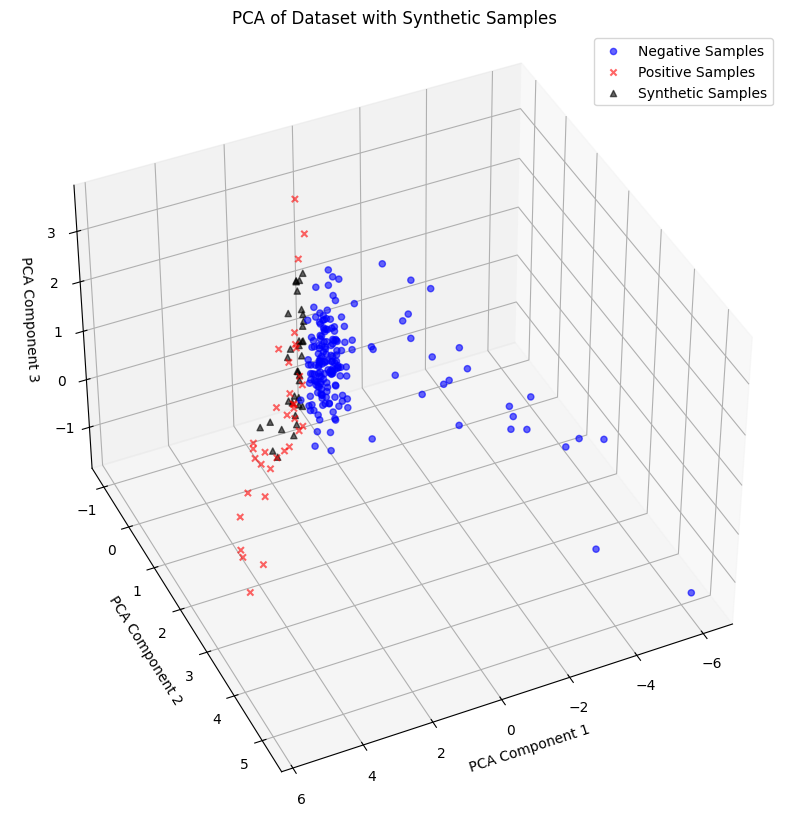

In [ ]:
''' testing / visualizing the tetrahedrons'''
file_path = r'D:\data\newdata.csv'  # Path of the dataset
target_column = 'Class'  # Target column with class labels
main(file_path, target_column, elev=40, azim=65)